<a href="https://colab.research.google.com/github/MaximeSzymanski/VAE_pytorch/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# get mnist data
import torchvision
from torchvision import datasets, transforms


/Users/maximeszymanski/PycharmProjects/VAE_pytorch/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# get mnist data and transform to tensor, to the right device.
transform = transforms.Compose([
        transforms.ToTensor(),
        ])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



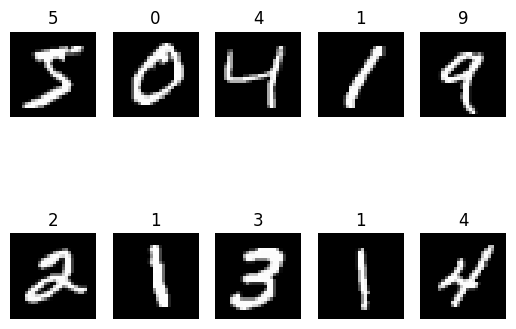

In [3]:
# plot 10 images
import matplotlib.pyplot as plt
import numpy as np
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_trainset[i][0].numpy().reshape(28, 28), cmap='gray')
    plt.title(mnist_trainset[i][1])
    plt.axis('off')

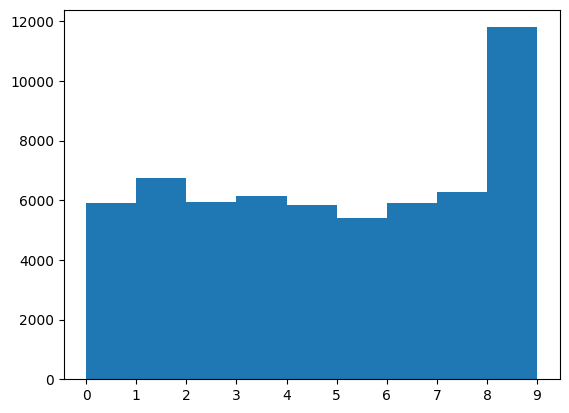

In [4]:
# plot the distribution of labels, with one color for each label
labels = mnist_trainset.targets.numpy()
plt.hist(labels, bins=np.arange(labels.min(), labels.max()+1))
plt.xticks(np.arange(labels.min(), labels.max()+1))
plt.show()

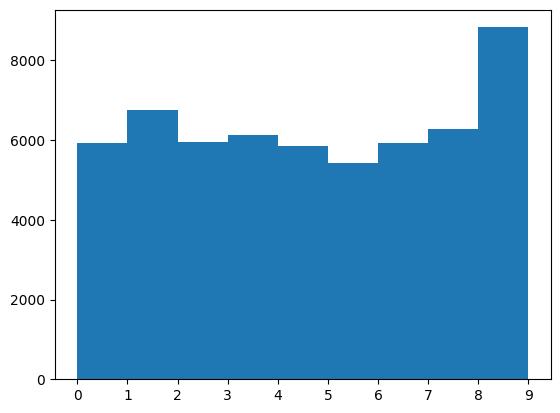

In [5]:
# remove half of the 9s from the training set, to have a more balanced dataset
# we will use this dataset to train the encoder
# get the indices of the 9s
nines = np.where(labels==9)[0]
# shuffle the indices
np.random.shuffle(nines)
# keep only half of the indices
nines = nines[:len(nines)//2]
# remove the 9s from the training set
mnist_trainset.data = torch.cat([mnist_trainset.data[labels!=9], mnist_trainset.data[nines]])
mnist_trainset.targets = torch.cat([mnist_trainset.targets[labels!=9], mnist_trainset.targets[nines]])

# plot the distribution of labels, with one color for each label
labels = mnist_trainset.targets.numpy()
plt.hist(labels, bins=np.arange(labels.min(), labels.max()+1))
plt.xticks(np.arange(labels.min(), labels.max()+1))
plt.show()

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(64*7*7, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):
        # x: batch_size * 1 * 28 * 28
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 64 * 28 * 28
        # flatten
        x = x.view(-1, 64*7*7)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        x = self.fc2(x)
        # x: batch_size * latent_dim
        return x

In [7]:
encoder = Encoder(1, 128, 2)

In [8]:
print(encoder)

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


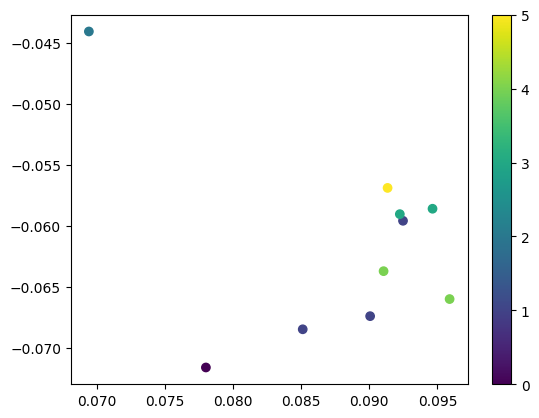

In [9]:
# encode the first 10 images
images = mnist_trainset.data[:10].float().unsqueeze(1)/255
encoder(images)
# plot the encoded images in 2D
encoded_images = encoder(images).detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets[:10].numpy())
plt.colorbar()
plt.show()

In [10]:
class SamplingLayer(torch.nn.Module):
    def __init__(self):
        super(SamplingLayer, self).__init__()

    def forward(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

class VariationalEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)


        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(512, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar = torch.nn.Linear(hidden_dim, latent_dim)
        self.sampling = SamplingLayer()

    def forward(self, x):
        original_x = x
        # x: batch_size * 1 * 28 * 28
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * 64 * 28 * 28
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)

        # flatten
        x = torch.nn.Flatten(start_dim=1)(x)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        mu = self.mu(x)
        sigma = self.logvar(x)
        z = self.sampling(mu, sigma)
        # print the shape
        """print(f'original_x: {original_x.shape}')
        print(f'mu: {mu.shape}')
        print(f'sigma: {sigma.shape}')
        print(f'z: {z.shape}')"""

        # x: batch_size * latent_dim
        return z, mu, sigma, original_x

In [11]:
class VariationalDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VariationalDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Fully connected layer
        self.fc1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 3 * 3 * 32 )

        # Transpose Convolutional layers
        self.t_conv1 = torch.nn.ConvTranspose2d(32, 16, kernel_size=7, stride=2, padding=0)
        self.t_conv2 = torch.nn.ConvTranspose2d(16, 8, kernel_size=7, stride=2, padding=0)
        self.t_conv3 = torch.nn.ConvTranspose2d(8, 1, kernel_size=4, stride=1, padding=1)



    def forward(self, x):
        batch_size = x.size(0)

        # x: batch_size * latent_dim
        x = self.fc1(x)
        x = torch.nn.functional.leaky_relu(x)
        # x: batch_size * hidden_dim
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.Unflatten(1, (32, 3, 3))(x)
        # x: batch_size * hidden_dim * 1 * 1
        x = self.t_conv1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * 64 * 2 * 2
        x = self.t_conv2(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * 32 * 4 * 4
        x = self.t_conv3(x)
        x = torch.nn.functional.sigmoid(x)

        #x = torch.sigmoid(x)
        # x: batch_size * 1 * 4 * 4
        return x


In [12]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z, mu, sigma, original_x = self.encoder(x)
        x = self.decoder(z)
        return x, mu, sigma, original_x

In [13]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(original_x, x):


    return torch.nn.functional.binary_cross_entropy(x, original_x, reduction='sum')

def loss_function(x, original_x, mu, sigma,k1=1,k2=1e-3):

    return k1 *reconstruction_loss(original_x, x) + k2 * KL_loss(mu, sigma)

In [14]:

variational_autoencoder = VariationalAutoEncoder(1, 128, 2)
variational_autoencoder.to(device)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=512, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=2, bias=True)
    (logvar): Linear(in_features=128, out_features=2, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=288, bias=True)
    (t_conv1): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 8, kernel_size=(7, 7), stride=(2, 2))
    (t_conv3): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

decoded shape : torch.Size([1, 1, 28, 28])


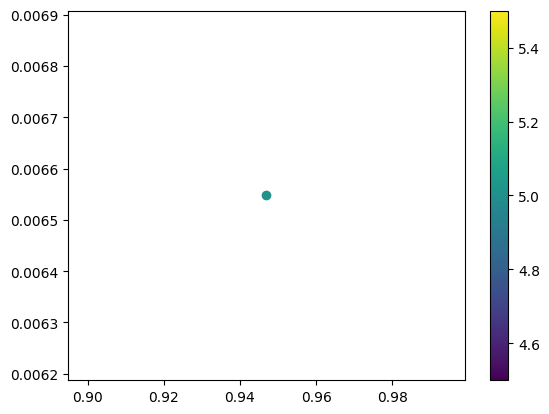

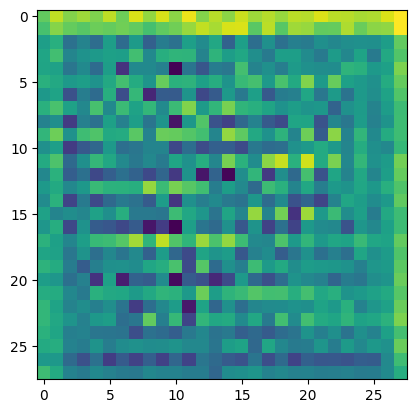

In [15]:
# encode the first 10 images
images = mnist_trainset.data[1].float().unsqueeze(0).unsqueeze(1)/255
images = images.to(device)
encoded, _ ,_ ,_ = variational_autoencoder.encoder(images)
decoded = variational_autoencoder.decoder(encoded) * 255
print(f"decoded shape : {decoded.shape}")

# plot the encoded images in 2D, and the decoded images
encoded_images = encoded.cpu().detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets[0].numpy())
plt.colorbar()
plt.show()
plt.imshow(decoded[0, 0].cpu().detach().numpy())
plt.show()



In [16]:
print(variational_autoencoder)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=512, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=2, bias=True)
    (logvar): Linear(in_features=128, out_features=2, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=288, bias=True)
    (t_conv1): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 8, kernel_size=(7, 7), stride=(2, 2))
    (t_conv3): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


In [17]:
batch_size = 64
lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=lr)


In [18]:

# take inly 10 images
#mnist_trainset.data = mnist_trainset.data[:nb_image_to_overfit]
#mnist_trainset.targets = mnist_trainset.targets[:nb_image_to_overfit]


mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


In [19]:
def train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0

        for i, (images, _) in enumerate(mnist_trainloader):
            # plot the first image of the first batch

            # check if images is full of 0
            images = images.float()
            # count number of non 0 in the tensor


            images = images.to(device)
            x, mu, sigma, original_x = variational_autoencoder(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss/len(mnist_trainloader.dataset)}')


In [39]:
train(10000)

Epoch: 1, Loss: 142.96081426595052
Epoch: 2, Loss: 141.5223018798828
Epoch: 3, Loss: 140.40492922363282
Epoch: 4, Loss: 139.61158212890626
Epoch: 5, Loss: 138.78435104980468
Epoch: 6, Loss: 138.18481569010416


KeyboardInterrupt: 

60000
60000


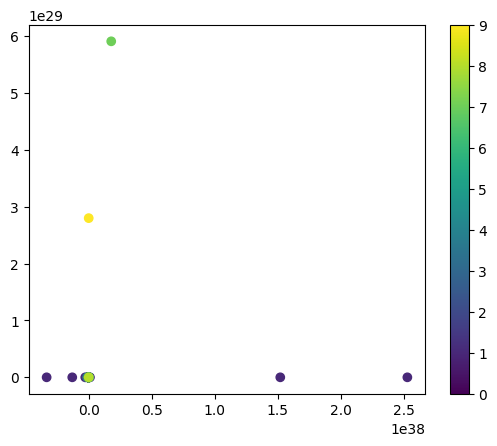

In [40]:
# take all images from the train set
with torch.no_grad():
  images = mnist_trainset.data.float().unsqueeze(1)
  print(len(mnist_trainset.data))
  print(len(mnist_trainset.targets))
  images = images.to(device)
  encoded = variational_autoencoder.encoder( images)
  decoded = variational_autoencoder.decoder( encoded[0])
  # plot the encoded images in 2D, and the decoded images
  encoded_images = encoded[0].cpu().detach().numpy()
  plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets.numpy())
  plt.colorbar()
  plt.show()


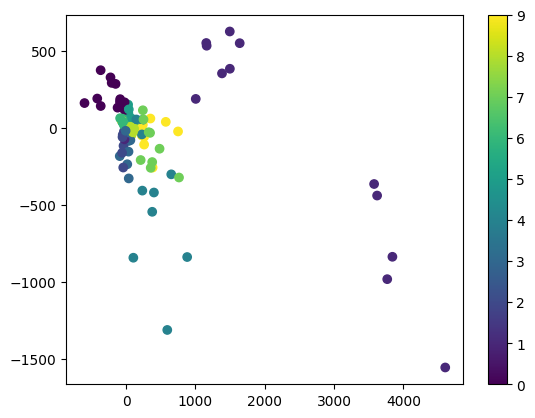

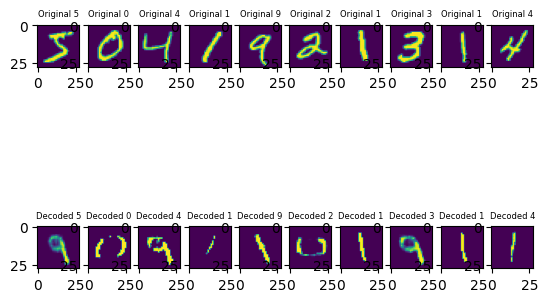

In [41]:
# take 10 images from the train set
with torch.no_grad():
  images = mnist_trainset.data[:100].float().unsqueeze(1)
  images = images.to(device)
  encoded = variational_autoencoder.encoder( images)
  decoded = variational_autoencoder.decoder( encoded[0])
  # plot the encoded images in 2D, and the decoded images
  encoded_images = encoded[0].cpu().detach().numpy()
  plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets[:100].numpy())
  plt.colorbar()
  plt.show()
  # plot the decoded images, in a 2 by 5 grid, with the original images on top of each decoded of the decoded images, and the label of the original image

  f, axarr = plt.subplots(2, 10)
  for i in range(10):
      # original images
      # write Original on top of the image
      axarr[0, i].set_title(f'Original {mnist_trainset.targets[i]}', fontsize=6)
      axarr[0, i].imshow(images[i, 0].cpu().detach().numpy())

      # decoded images
      # write Decoded on top of the image
      axarr[1, i].set_title(f'Decoded {mnist_trainset.targets[i]}', fontsize=6)
      axarr[1, i].imshow(decoded[i, 0].cpu().detach().numpy())

  plt.show()
